# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

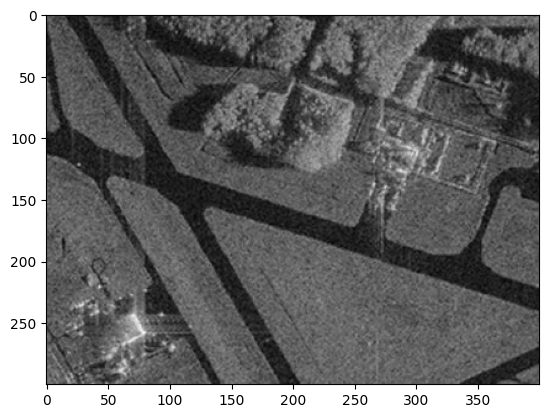

In [4]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

In [5]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
        
    return mask*255

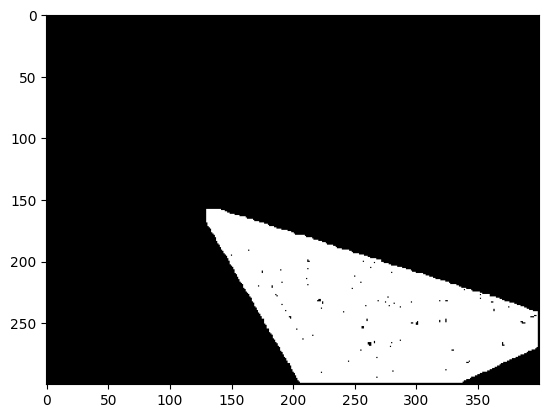

In [6]:
seed_point = (158,130)
res = region_growing(image_gray,seed_point,homo_average,1, 25)
plt.imshow(res, cmap='gray')
plt.show()

# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [7]:
def homo_median(image, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    
    median_val = np.median(image[mask > 0])
    
    if abs(median_val - image[point]) <= T:
        return True
    
    return False


In [8]:
seed_point = (158,130)
res_median = region_growing(image_gray,seed_point,homo_median,1, 25)

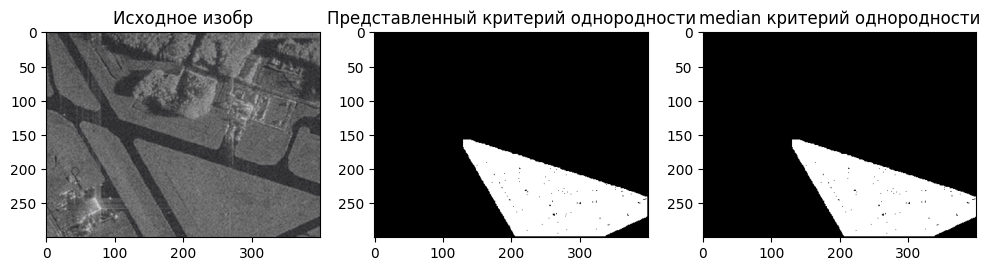

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1); plt.imshow(image, cmap='gray')
plt.title('Исходное изобр')
plt.subplot(1, 3, 2); plt.imshow(res, cmap='gray')
plt.title('Представленный критерий однородности')
plt.subplot(1, 3, 3); plt.imshow(res_median, cmap='gray'); 
plt.title('median критерий однородности')
plt.show()

In [10]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim, _) = structural_similarity(image_gray, res, full=True)
(ssim_median, _) = structural_similarity(image_gray, res_median, full=True)

mse = mean_squared_error(image_gray, res)
mse_median = mean_squared_error(image_gray, res_median)

print("Результаты сравнения:")
print(f"res и image: SSIM = {ssim:.4f}; MSE = {mse:.4f}")
print(f"res_median и img: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")

Результаты сравнения:
res и image: SSIM = 0.0602; MSE = 11060.1966
res_median и img: SSIM = 0.0609; MSE = 11059.8672


## Вывод: шум в виде черных точек слегка меньше в median варианте, чем в представленном

# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

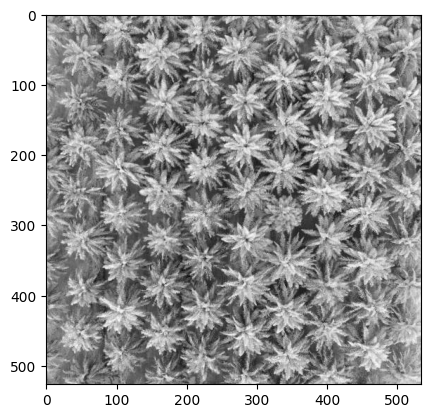

In [11]:
image = cv2.imread('palm_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")
plt.show()

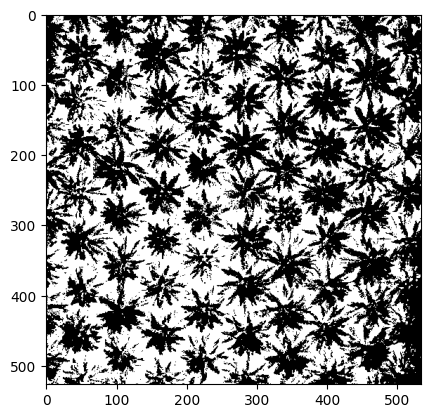

In [12]:
image_gray = cv2.bitwise_not(image_gray)
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

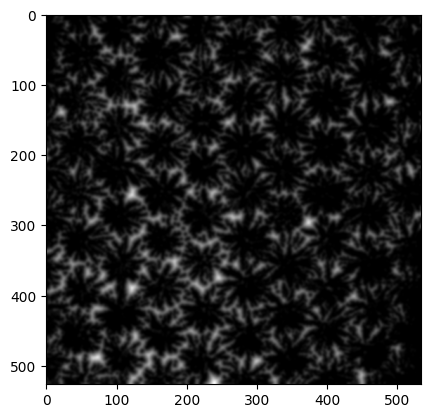

In [13]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
dist_blur = cv2.GaussianBlur(dist, (7,7), 0)
plt.imshow(dist_blur, cmap="gray")

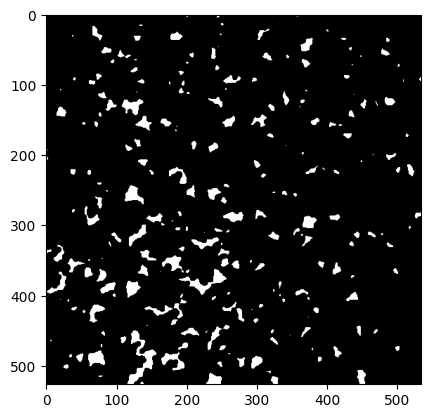

In [14]:
ret, sure_fg = cv2.threshold(dist_blur, 0.32 * dist_blur.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

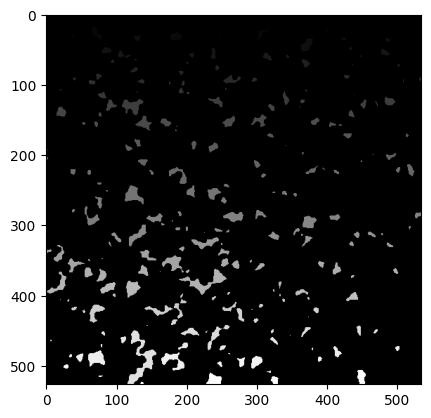

In [15]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg) 
plt.imshow(markers, cmap="gray")

Примерное кол-во пальм: 238


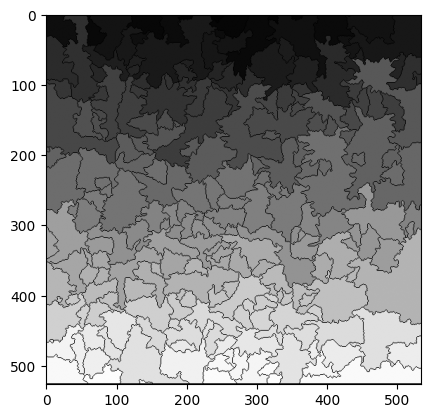

In [16]:
markers = cv2.watershed(image, markers)
plt.imshow(markers, cmap="gray")
print('Примерное кол-во пальм:', len(np.unique(markers)))